# Two Towers Model
- based on word2vec embeddings from gensim
- use a simple average of the word embeddings as the document embedding
- use a simple feedforward neural network as the encoder


In [1]:

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim
import pandas as pd
import gensim.downloader as api
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.preprocess_str import preprocess_list as preprocess

[nltk_data] Downloading package stopwords to /Users/x25bd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/x25bd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
random_seed = 42  # You can choose any integer value
pd.set_option('mode.chained_assignment', None)  # Suppress SettingWithCopyWarning
np.random.seed(random_seed)

In [4]:
#PREPROCESS text8
raw_corpus = api.load('text8')

In [5]:
corpus = [preprocess(doc) for doc in raw_corpus]

In [6]:
w2v = gensim.models.Word2Vec(corpus, vector_size=100, window=5, min_count=3, workers=4)
w2v.save('./word2vec/word2vec-gensim-text8-custom-preprocess.model')

In [7]:
# Load the word2vec model, extract embeddings, convert to torch tensor
# w2v = gensim.models.Word2Vec.load('./word2vec/word2vec-gensim-text8-custom-preprocess.model')
vocab = w2v.wv.index_to_key
word_to_idx = {word: i for i, word in enumerate(vocab)}
embeddings_array = np.array([w2v.wv[word] for word in vocab])
embeddings = torch.tensor(embeddings_array, dtype=torch.float32)
print(embeddings.shape)

torch.Size([74792, 100])


In [101]:
embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=True)
word_index = torch.tensor([word_to_idx['north']], dtype=torch.long)


In [17]:
df = pd.read_parquet('../data/training.parquet')
df = df.sample(n=10000, random_state=random_seed)

In [18]:
df = df[['document', 'query', 'relevance']].copy()
df.reset_index(inplace=True)


In [21]:
def str_to_tokens(s):
    split = preprocess(s)
    return [word_to_idx[word] for word in split if word in word_to_idx]



In [22]:
df.loc[:, 'document_tokens'] = df['document'].apply(str_to_tokens)
df.loc[:, 'query_tokens'] = df['query'].apply(str_to_tokens)


In [103]:
df.head()

,index,document,query,relevance,document_tokens,query_tokens,query_length,document_length
0,543005,10 years is not old for a boiler. Ask the serv...,what is fluoxetine used for,0,"[1133, 62, 222, 122, 270, 142, 222, 28, 270, 6...","[1133, 543, 263, 142, 270, 107, 77, 62, 122, 6...",15,192
1,1119141,Gabapentin is a generic for neurontin. Vicodin...,is neurontin a narcotic medication,1,"[1133, 112, 28, 224, 62, 122, 122, 112, 62, 12...","[1133, 122, 62, 107, 222, 122, 122, 122, 222, ...",15,155
2,1402220,What To Expect After Surgery. The hospital sta...,keflex medication uses,0,"[1133, 543, 263, 62, 77, 224, 62, 72, 30630, 1...","[1133, 308, 62, 142, 270, 62, 77, 62, 72, 122,...",13,252
3,1366415,"The result, a lot of the time, is a lost carp!...",can you use a chod rig without lead core,1,"[1133, 263, 62, 222, 62, 107, 270, 270, 142, 2...","[1133, 72, 122, 107, 107, 62, 72, 263, 222, 11...",19,197
4,13131,Removing or filling in a wood or steel walled ...,cost to fill in a pool,1,"[1133, 222, 62, 330, 122, 112, 222, 142, 270, ...","[1133, 72, 142, 270, 270, 122, 224, 270, 1134]",9,126


In [24]:
df['query_length'] = df['query_tokens'].apply(len)
df['document_length'] = df['document_tokens'].apply(len)



SEQ_LENGTH: ~30


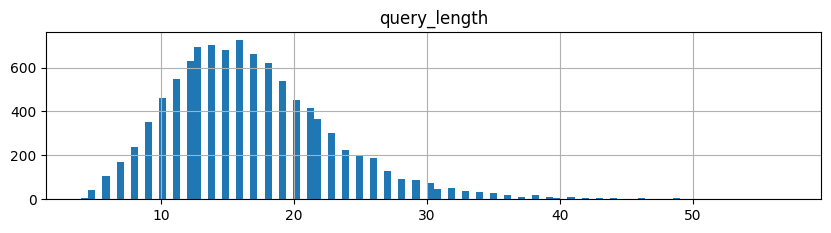

In [34]:
df[['query_length']].hist(bins=100, layout=(2,1 ), figsize=(10, 5))
print('SEQ_LENGTH: ~30')


array([[<Axes: title={'center': 'document_length'}>],
       [<Axes: >]], dtype=object)

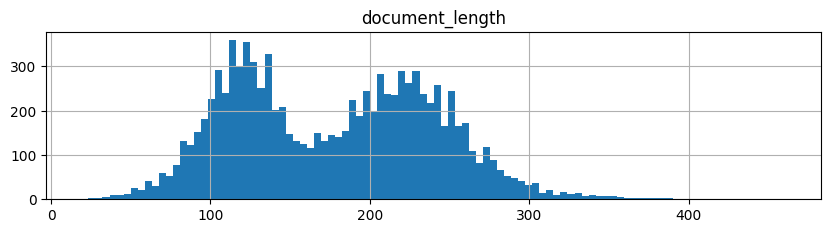

In [60]:
df[['document_length']].hist(bins=100, layout=(2,1 ), figsize=(10, 5))



In [53]:
def embed_tokens(tokens):
    embed_tensor = [torch.tensor(embedding_layer(torch.tensor(t, dtype=torch.long)), dtype=torch.float32) for t in tokens]
    embed_tensor = torch.stack(embed_tensor)
    return embed_tensor



In [42]:
class DocumentDataset(Dataset):
    def __init__(self, df_input):
        self.documents = df_input['document_tokens']
        self.queries = df_input['query_tokens']
        self.labels = df_input['relevance']

    def __len__(self):
        return len(self.documents)
    
    def __getitem__(self, idx):
        return (
            # This outputs tensors of token indices — variable length
                # NOT embeddings
            torch.tensor(self.documents.iloc[idx], dtype=torch.long),
            torch.tensor(self.queries.iloc[idx], dtype=torch.long),
            # This will be a scalar float
            torch.tensor(self.labels.iloc[idx], dtype=torch.float32),
        )



In [65]:
def collate(batch):
    docs, queries, labels = zip(*batch)
    docs = pad_sequence(docs, batch_first=True, padding_value=0)
    queries = pad_sequence(queries, batch_first=True, padding_value=0)

    # Create masks
    doc_mask = (docs != 0).float()
    query_mask = (queries != 0).float()
    labels = torch.tensor(labels, dtype=torch.float32)
    return docs, queries, doc_mask, query_mask, labels


# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)


In [67]:
dataset = DocumentDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate)

In [76]:
i = 0
for docs, queries, doc_mask, query_mask, labels in dataloader:
    print('Batch', i + 1)
    print("Documents shape:", docs.shape)
    print("Queries shape:", queries.shape)
    print("Document mask shape:", doc_mask.shape)
    print("Query mask shape:", query_mask.shape)
    print("Labels shape:", labels.shape)
    print(docs)
    i += 1
    if i > 3:
        break  # Just print the first batch


Batch 1
Documents shape: torch.Size([32, 324])
Queries shape: torch.Size([32, 35])
Document mask shape: torch.Size([32, 324])
Query mask shape: torch.Size([32, 35])
Labels shape: torch.Size([32])
tensor([[ 1133,    62,   222,  ...,     0,     0,     0],
        [ 1133,   112,    28,  ...,     0,     0,     0],
        [ 1133,   543,   263,  ...,     0,     0,     0],
        ...,
        [ 1133, 30630,   263,  ...,     0,     0,     0],
        [ 1133,   543,   122,  ...,     0,     0,     0],
        [ 1133,   107,   222,  ...,     0,     0,     0]])
Batch 2
Documents shape: torch.Size([32, 319])
Queries shape: torch.Size([32, 38])
Document mask shape: torch.Size([32, 319])
Query mask shape: torch.Size([32, 38])
Labels shape: torch.Size([32])
tensor([[ 1133, 42359,   122,  ...,   263,   222,  1134],
        [ 1133,    72,    62,  ...,     0,     0,     0],
        [ 1133,   263,    62,  ...,     0,     0,     0],
        ...,
        [ 1133,   263,    62,  ...,     0,     0,     0],
 

In [93]:
class TwoTowerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, embedding_layer):
        super(TwoTowerModel, self).__init__()
        
        self.embedding = embedding_layer

        self.doc_rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)

        self.query_rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
    
    def forward(self, doc_ids, query_ids):
        # do we need to zero out the hidden state?
        doc_embed = self.embedding(doc_ids)
        query_embed = self.embedding(query_ids)

        _, doc_hidden = self.doc_rnn(doc_embed)
        _, query_hidden = self.query_rnn(query_embed)

        doc_encoded = doc_hidden[-1] # average across timesteps
        query_encoded = query_hidden[-1]
        
        similarity = F.cosine_similarity(doc_encoded, query_encoded, dim=1)

        return similarity

    # Loss
        # s = cosine_similarity(hd_n, hq_n)
        # if relevance == 0, s should be low
        # if relevance == 1 or 2, s should be high
        
    # Backprop


In [94]:
model = TwoTowerModel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, num_layers=1, embedding_layer=embedding_layer)

In [95]:
print(model)

TwoTowerModel(
  (embedding): Embedding(74792, 100)
  (doc_rnn): RNN(100, 128, batch_first=True)
  (query_rnn): RNN(100, 128, batch_first=True)
)


In [96]:
model.eval()

TwoTowerModel(
  (embedding): Embedding(74792, 100)
  (doc_rnn): RNN(100, 128, batch_first=True)
  (query_rnn): RNN(100, 128, batch_first=True)
)

In [97]:
dataiter = iter(dataloader)
docs, queries, doc_mask, query_mask, labels = next(dataiter)

print(docs.shape)
print(queries.shape)
print(doc_mask.shape)
print(query_mask.shape)
print(labels.shape)

torch.Size([32, 324])
torch.Size([32, 35])
torch.Size([32, 324])
torch.Size([32, 35])
torch.Size([32])


In [98]:
doc = docs[0].unsqueeze(0)
query = queries[0].unsqueeze(0)

In [99]:
with torch.no_grad():
    similarity = model(doc, query)

In [100]:

print("Input document shape:", doc.shape)
print("Input query shape:", query.shape)
print("Output similarity:", similarity.item())

# If you want to see the actual document and query
print("\nDocument tokens:", doc.squeeze().tolist())
print("Query tokens:", query.squeeze().tolist())

# If you have a way to convert token IDs back to words, you could use it here
# print("Document:", convert_ids_to_words(doc.squeeze().tolist()))
# print("Query:", convert_ids_to_words(query.squeeze().tolist()))

print("\nTrue label:", labels[0].item())

Input document shape: torch.Size([1, 324])
Input query shape: torch.Size([1, 35])
Output similarity: -0.022176172584295273

Document tokens: [1133, 62, 222, 122, 270, 142, 222, 28, 270, 62, 222, 30630, 308, 263, 62, 62, 222, 330, 72, 62, 122, 543, 263, 263, 224, 62, 107, 222, 28, 270, 62, 222, 122, 42359, 72, 62, 543, 122, 142, 107, 543, 122, 308, 62, 72, 263, 122, 72, 62, 122, 263, 330, 62, 142, 62, 543, 222, 62, 62, 222, 107, 142, 263, 62, 28, 270, 62, 222, 122, 72, 263, 122, 112, 62, 122, 122, 263, 330, 62, 543, 222, 222, 28, 107, 42359, 142, 107, 72, 263, 122, 112, 62, 112, 62, 122, 62, 543, 263, 330, 62, 222, 112, 543, 222, 222, 122, 543, 263, 122, 122, 122, 72, 62, 28, 270, 62, 222, 263, 107, 270, 270, 62, 222, 30630, 72, 28, 28, 270, 62, 222, 107, 62, 222, 62, 263, 122, 122, 263, 62, 222, 28, 270, 62, 222, 28, 62, 72, 107, 62, 142, 72, 122, 122, 62, 122, 30630, 263, 62, 62, 77, 72, 263, 122, 112, 62, 222, 222, 62, 224, 270, 72, 62, 62, 122, 107, 263, 330, 62, 72, 122, 62, 222, 1